# Time Series Forecasting

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

In [2]:
def createDelayedColumns(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

def convert3D(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

def plot_predictions(*named_predictions, start=None, end=None, **kwargs):
    day_range = slice(start, end)
    plt.figure(figsize=(10,5))
    for name, y_pred in named_predictions:
        if hasattr(y_pred, "values"):
            y_pred = y_pred.values
        plt.plot(y_pred[day_range], label=name, **kwargs)
    plt.legend()
    plt.show()
    
def plot_history(history, loss="loss"):
    train_losses = history.history[loss]
    valid_losses = history.history["val_" + loss]
    n_epochs = len(history.epoch)
    minloss = np.min(valid_losses)
    
    plt.plot(train_losses, color="b", label="Train")
    plt.plot(valid_losses, color="r", label="Validation")
    plt.plot([0, n_epochs], [minloss, minloss], "k--",
             label="Min val: {:.2f}".format(minloss))
    plt.axis([0, n_epochs, 0, 20])
    plt.legend()
    plt.show()


### Daily minimum temperatures in Melbourne from 1981 to 1990 

In [3]:
dailyTemps = pd.read_csv("data/daily-minimum-temperatures.csv", 
                        parse_dates=[0], index_col=[0])

In [4]:
dailyTemps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
dailyTemps.tail()

,Temperature
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [6]:
print(dailyTemps.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB
None


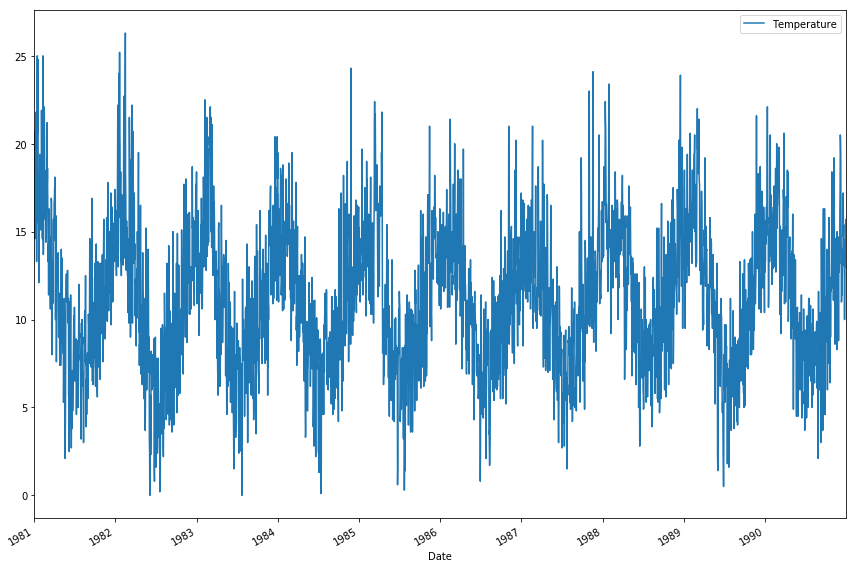

In [7]:
dailyTemps.plot(figsize=(12,8))
plt.savefig("f1.png", format='png', dpi=300)
plt.tight_layout()
plt.show()

### Based on previous 7 days minimum temperature, predict the minimum temperature after two days

In [8]:
previousDays = 7
afterDays = 2

X = createDelayedColumns(dailyTemps, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(dailyTemps, times=[afterDays]).iloc[previousDays:-afterDays]

In [9]:
X.head()

,t-6,t-5,t-4,t-3,t-2,t-1,t
,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature,Temperature
Date,,,,,,,
1981-01-08,17.9,18.8,14.6,15.8,15.8,15.8,17.4
1981-01-09,18.8,14.6,15.8,15.8,15.8,17.4,21.8
1981-01-10,14.6,15.8,15.8,15.8,17.4,21.8,20.0
1981-01-11,15.8,15.8,15.8,17.4,21.8,20.0,16.2
1981-01-12,15.8,15.8,17.4,21.8,20.0,16.2,13.3


In [10]:
y.head()

,t+2
,Temperature
Date,
1981-01-08,20.0
1981-01-09,16.2
1981-01-10,13.3
1981-01-11,16.7
1981-01-12,21.5


In [11]:
train_slice = slice(None, "1988-12-28")
test_slice = slice("1989-01-01", None)

In [12]:
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

In [13]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2911 entries, 1981-01-08 to 1988-12-28
Data columns (total 7 columns):
(t-6, Temperature)    2911 non-null float64
(t-5, Temperature)    2911 non-null float64
(t-4, Temperature)    2911 non-null float64
(t-3, Temperature)    2911 non-null float64
(t-2, Temperature)    2911 non-null float64
(t-1, Temperature)    2911 non-null float64
(t, Temperature)      2911 non-null float64
dtypes: float64(7)
memory usage: 181.9 KB
None


In [14]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 728 entries, 1989-01-01 to 1990-12-29
Data columns (total 7 columns):
(t-6, Temperature)    728 non-null float64
(t-5, Temperature)    728 non-null float64
(t-4, Temperature)    728 non-null float64
(t-3, Temperature)    728 non-null float64
(t-2, Temperature)    728 non-null float64
(t-1, Temperature)    728 non-null float64
(t, Temperature)      728 non-null float64
dtypes: float64(7)
memory usage: 45.5 KB
None


In [15]:
# RNN needs the input to be 3D

X_train_3D = convert3D(X_train)
X_test_3D = convert3D(X_test)

In [16]:
print(X_train_3D.shape, X_test_3D.shape)

(2911, 7, 1) (728, 7, 1)


## Simple RNN

In [17]:
model_simpleRNN = keras.models.Sequential()
model_simpleRNN.add(keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(7,1)))
model_simpleRNN.add(keras.layers.SimpleRNN(25))
model_simpleRNN.add(keras.layers.Dense(1))

model_simpleRNN.compile(loss="mse", optimizer="adam", metrics=["mae"])
model_simpleRNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 7, 50)             2600      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25)                1900      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 4,526
Trainable params: 4,526
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_simpleRNN = model_simpleRNN.fit(X_train_3D, y_train, epochs=20, 
                                        batch_size=20, validation_split=0.1)

Train on 2619 samples, validate on 292 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2619/2619 [==============================] - 2s 722us/sample - loss: 47.0250 - mean_absolute_error: 5.6134 - val_loss: 21.0182 - val_mean_absolute_error: 3.6432
Epoch 2/20
2619/2619 [==============================] - 1s 241us/sample - loss: 20.3121 - mean_absolute_error: 3.5648 - val_loss: 13.6193 - val_mean_absolute_error: 2.9288
Epoch 3/20
2619/2619 [==============================] - 1s 215us/sample - loss: 14.5137 - mean_absolute_error: 2.9614 - val_loss: 10.7660 - val_mean_absolute_error: 2.6129
Epoch 4/20
2619/2619 [==============================] - 1s 215us/sample - loss: 11.2207 - mean_absolute_error: 2.5863 - val_loss: 9.1201 - val_mean_absolute_error: 2.3917
Epoch 5/20
2619/2619 [==============================] - 1s 215us/sample - loss: 9.9943 - mean_absolute_error: 2.4357 - val_loss: 9.4156 - val_mean_absolute_error: 2.4385
Epoch 6/20
2619/2619 [==========================

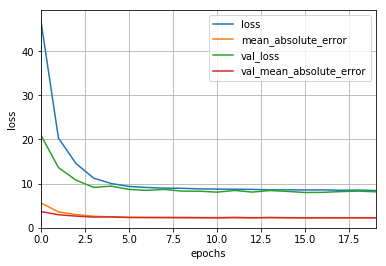

In [19]:
pd.DataFrame(history_simpleRNN.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

## LSTM

In [20]:
model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.LSTM(50, return_sequences=True, input_shape=(7,1)))
model_LSTM.add(keras.layers.LSTM(25))
model_LSTM.add(keras.layers.Dense(1))

model_LSTM.compile(loss="mse", optimizer="adam", metrics=["mae"])
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_LSTM = model_LSTM.fit(X_train_3D, y_train, epochs=20, 
                                        batch_size=20, validation_split=0.1)

Train on 2619 samples, validate on 292 samples
Epoch 1/20
2619/2619 [==============================] - 4s 1ms/sample - loss: 51.4251 - mean_absolute_error: 5.9208 - val_loss: 20.5605 - val_mean_absolute_error: 3.5978
Epoch 2/20
2619/2619 [==============================] - 2s 803us/sample - loss: 20.3234 - mean_absolute_error: 3.5685 - val_loss: 13.5158 - val_mean_absolute_error: 2.9550
Epoch 3/20
2619/2619 [==============================] - 2s 788us/sample - loss: 17.1789 - mean_absolute_error: 3.3025 - val_loss: 12.5009 - val_mean_absolute_error: 2.8779
Epoch 4/20
2619/2619 [==============================] - 3s 982us/sample - loss: 15.7476 - mean_absolute_error: 3.1530 - val_loss: 10.7691 - val_mean_absolute_error: 2.6135
Epoch 5/20
2619/2619 [==============================] - 3s 1ms/sample - loss: 11.2455 - mean_absolute_error: 2.5918 - val_loss: 8.6519 - val_mean_absolute_error: 2.3499
Epoch 6/20
2619/2619 [==============================] - 2s 918us/sample - loss: 9.6894 - mean_abso

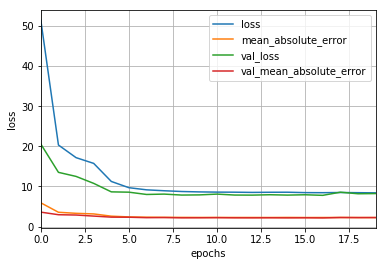

In [22]:
pd.DataFrame(history_LSTM.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

# GRU

In [23]:
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.GRU(50, return_sequences=True, input_shape=(7,1)))
model_GRU.add(keras.layers.GRU(25))
model_GRU.add(keras.layers.Dense(1))

model_GRU.compile(loss="mse", optimizer="adam", metrics=["mae"])
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 50)             7800      
_________________________________________________________________
gru_1 (GRU)                  (None, 25)                5700      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 13,526
Trainable params: 13,526
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_GRU = model_GRU.fit(X_train_3D, y_train, epochs=20, 
                                        batch_size=20, validation_split=0.1)

Train on 2619 samples, validate on 292 samples
Epoch 1/20
2619/2619 [==============================] - 3s 1ms/sample - loss: 37.6292 - mean_absolute_error: 4.9205 - val_loss: 15.5121 - val_mean_absolute_error: 3.1270
Epoch 2/20
2619/2619 [==============================] - 2s 657us/sample - loss: 17.5828 - mean_absolute_error: 3.3251 - val_loss: 12.0816 - val_mean_absolute_error: 2.7788
Epoch 3/20
2619/2619 [==============================] - 2s 813us/sample - loss: 12.5298 - mean_absolute_error: 2.7322 - val_loss: 9.7487 - val_mean_absolute_error: 2.4694
Epoch 4/20
2619/2619 [==============================] - 4s 1ms/sample - loss: 10.0407 - mean_absolute_error: 2.4424 - val_loss: 8.4650 - val_mean_absolute_error: 2.2931
Epoch 5/20
2619/2619 [==============================] - 3s 993us/sample - loss: 9.3423 - mean_absolute_error: 2.3657 - val_loss: 8.4030 - val_mean_absolute_error: 2.2815
Epoch 6/20
2619/2619 [==============================] - 2s 890us/sample - loss: 9.0283 - mean_absolut

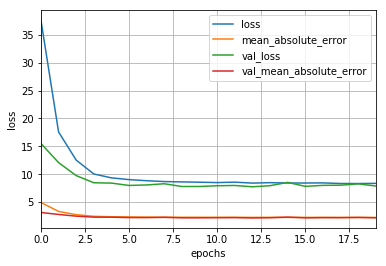

In [25]:
pd.DataFrame(history_GRU.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

# Results of all different versions of RNN

In [26]:
mae_simpleRNN = model_simpleRNN.evaluate(X_test_3D, y_test)
mae_LSTM = model_LSTM.evaluate(X_test_3D, y_test)
mae_GRU = model_GRU.evaluate(X_test_3D, y_test)

728/728 [==============================] - 0s 145us/sample - loss: 6.9208 - mean_absolute_error: 2.0560


In [27]:
print("mae_simpleRNN: ", mae_simpleRNN)
print("mae_LSTM: ", mae_LSTM)
print("mae_GRU: ", mae_GRU)

mae_simpleRNN:  [7.005211468581315, 2.0727673]
mae_LSTM:  [7.1071050088484204, 2.0879266]
mae_GRU:  [6.920812612051492, 2.0559785]
